# 📈 Stock Price Prediction with Linear Regression
This notebook builds a regression model to predict **Apple (AAPL)** stock’s next-day closing price using historical data, technical indicators, and baseline comparison.

---

## Step 0: Setup - Import Libraries


In [1]:
# =============================================================================
# Step 0: Setup - Import Libraries
# =============================================================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import joblib

# Create directories if they don't exist
os.makedirs('data', exist_ok=True)
os.makedirs('figures', exist_ok=True)
os.makedirs('models', exist_ok=True)


## Step 1: Define Scope & Baseline
- **Ticker**: Apple Inc. (AAPL)  
- **Time window**: 10 years  
- **Task**: Regression – predict `Close(t+1)`  
- **Model**: Linear Regression  
- **Features**: SMA, Volatility, Momentum, Lag Features  
- **Baseline**: `Close(t+1) = Close(t)`  

We will compare our model against this naive baseline.


In [2]:
TICKER = 'AAPL'
START_DATE = '2015-01-01'
END_DATE = '2025-01-01'

## Step 2: Get the Data
We’ll fetch data using `yfinance` and store it locally.

In [3]:
print("Step 2: Downloading data...")
data = yf.download(TICKER, start=START_DATE, end=END_DATE, interval='1d')
data.to_csv(f'data/raw_{TICKER}.csv')
print(f"Data downloaded for {TICKER} from {START_DATE} to {END_DATE}")
data.head()

Step 2: Downloading data...


C:\Users\HP5CD\AppData\Local\Temp\ipykernel_26880\2962662978.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE, interval='1d')
[*********************100%***********************]  1 of 1 completed

Data downloaded for AAPL from 2015-01-01 to 2025-01-01


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.261045,24.729268,23.821670,24.718172,212818400
2015-01-05,23.577574,24.110150,23.391173,24.030263,257142000
2015-01-06,23.579800,23.839430,23.218091,23.641933,263188400
2015-01-07,23.910433,24.010290,23.677430,23.788384,160423600
2015-01-08,24.829128,24.886824,24.121246,24.238858,237458000


## Step 3: Clean & Inspect
Check missing values, sort by date, and save processed data.

In [6]:
print("\nStep 3: Cleaning and inspecting data...")
df = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
df.sort_index(ascending=True, inplace=True)

print("Missing values check:")
print(df.isnull().sum())

print("\nData description:")
print(df.describe())

df.to_csv(f'data/processed_{TICKER}.csv')
print("Data cleaned and saved to processed file.")


Step 3: Cleaning and inspecting data...
Missing values check:
Price   Ticker
Open    AAPL      0
High    AAPL      0
Low     AAPL      0
Close   AAPL      0
Volume  AAPL      0
dtype: int64

Data description:
Price          Open         High          Low        Close        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03
mean      93.863011    94.862311    92.935270    93.949921  1.170853e+08
std       65.424438    66.098727    64.817392    65.504728  6.839614e+07
min       20.546423    20.927672    20.425440    20.624054  2.323470e+07
25%       35.277319    35.655408    34.878668    35.257093  7.105610e+07
50%       64.290825    65.005721    63.647708    64.450443  1.003646e+08
75%      150.202224   152.129393   148.411455   150.379650  1.426216e+08
max      257.276679   259.179926   256.718662   258.103729  6.488252e+08
Data cleaned and saved to processed file.


## Step 4: Exploratory Data Analysis (EDA)
We’ll visualize:  
- Closing price history  
- Moving averages  
- Daily returns  
- Volume trends  

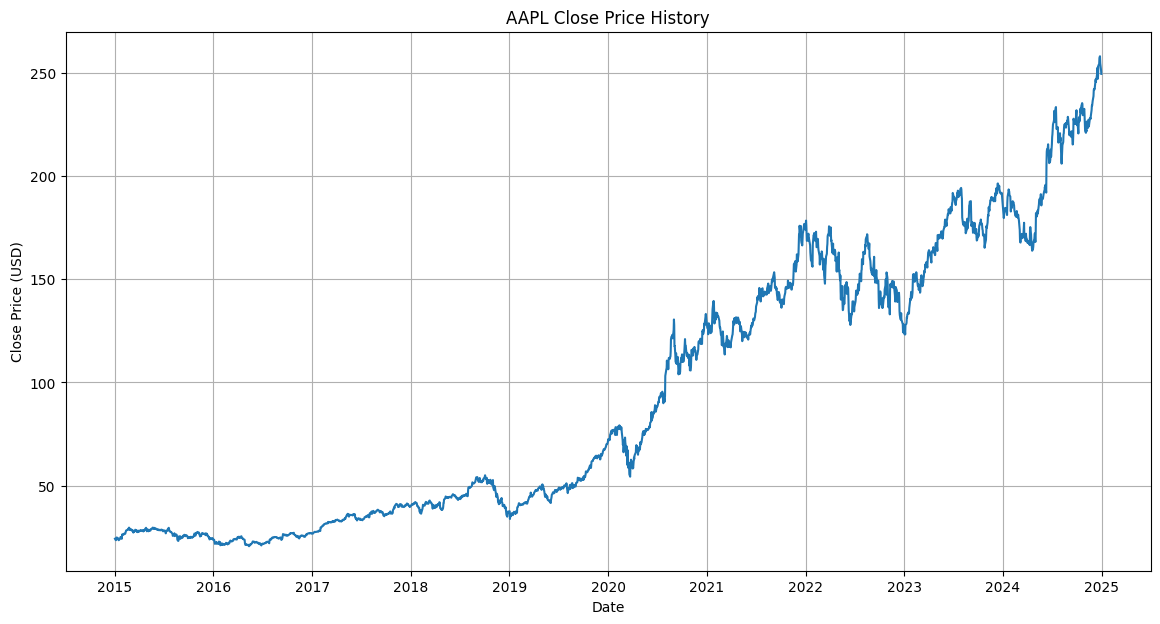

In [7]:
# Close price over time
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'])
plt.title(f'{TICKER} Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.show()

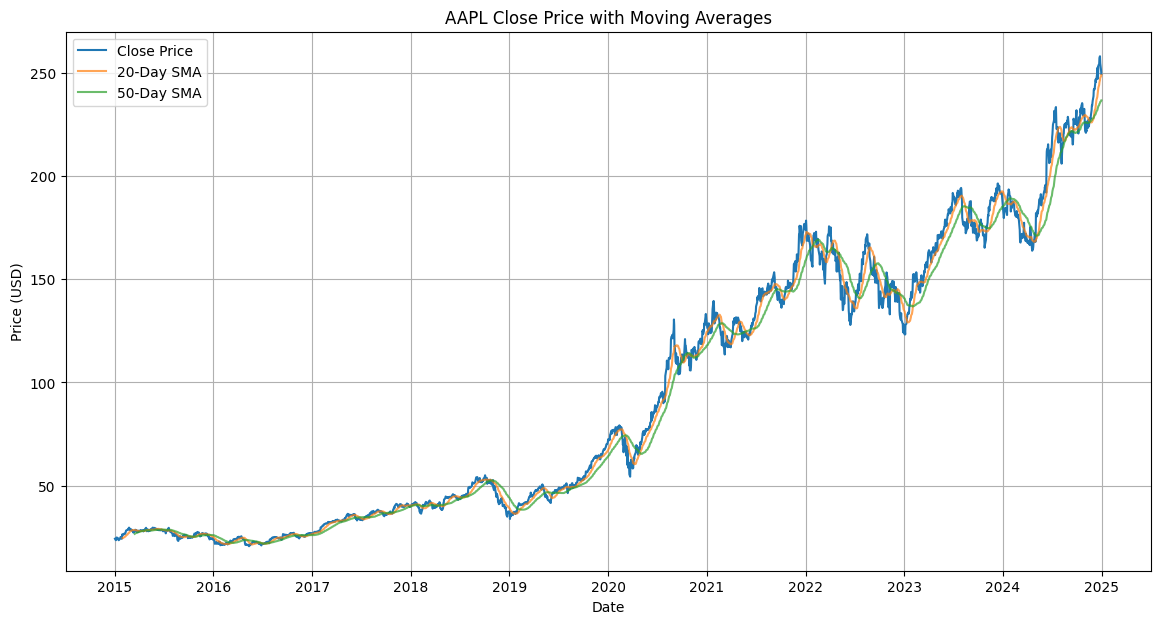

In [8]:
# Close with 20-day and 50-day SMA
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['SMA_20'], label='20-Day SMA', alpha=0.7)
plt.plot(df.index, df['SMA_50'], label='50-Day SMA', alpha=0.7)
plt.title(f'{TICKER} Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


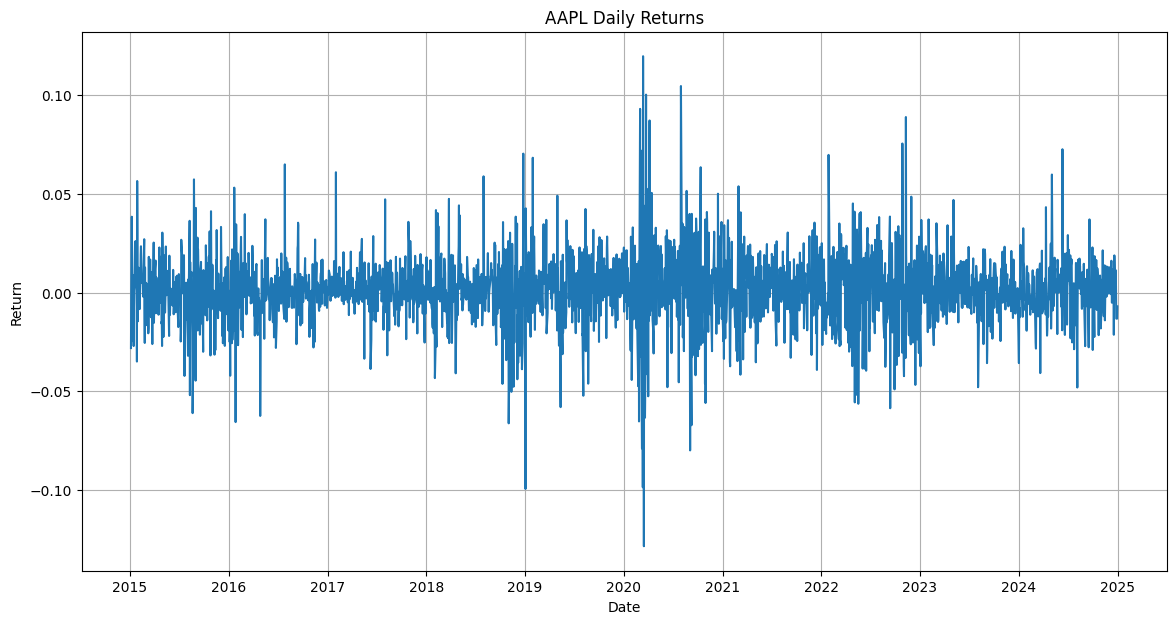

In [9]:
# Daily returns
df['Daily_Return'] = df['Close'].pct_change()
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Daily_Return'])
plt.title(f'{TICKER} Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.show()

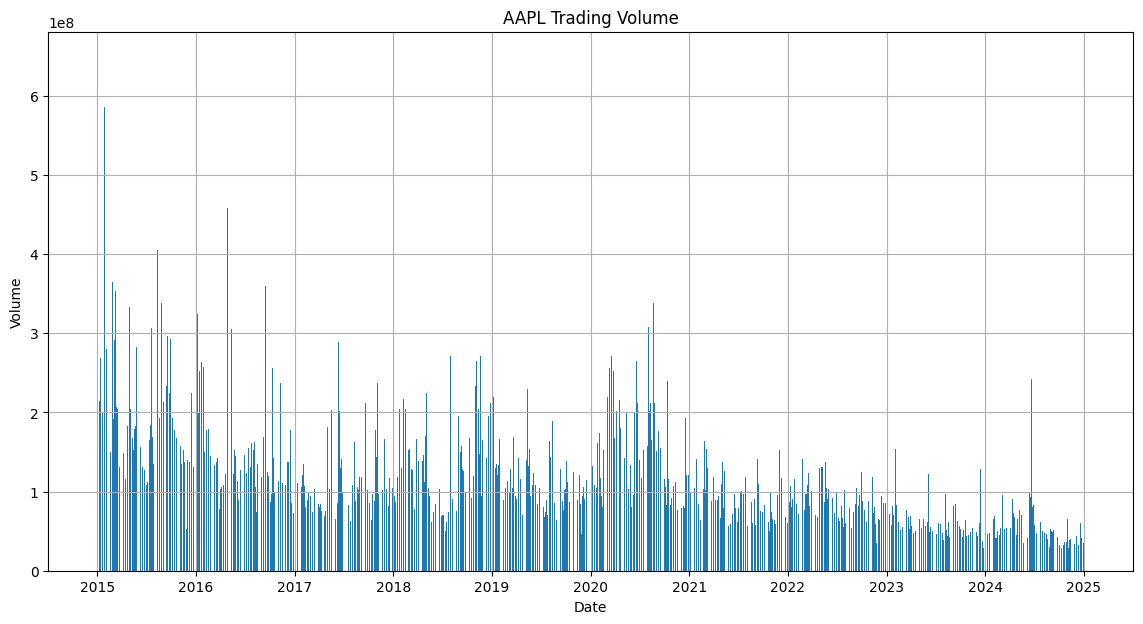

In [11]:
# Volume over time
plt.figure(figsize=(14, 7))
plt.bar(df.index, df[('Volume', 'AAPL')])
plt.title(f'{TICKER} Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()


## Step 5: Feature Engineering
We create technical indicators and lag features, then define the **target** (`Close(t+1)`).

In [12]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Technical Indicators
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['Volatility_20'] = df['Close'].pct_change().rolling(window=20).std()
df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
df['Min_20'] = df['Close'].rolling(window=20).min()
df['Max_20'] = df['Close'].rolling(window=20).max()

# Lag Features
df['Close_lag_1'] = df['Close'].shift(1)
df['Close_lag_2'] = df['Close'].shift(2)
df['Return_lag_1'] = df['Close'].pct_change().shift(1)

# Target Variable
df['Target'] = df['Close'].shift(-1)

df.dropna(inplace=True)
print("Features created. Final dataset shape:", df.shape)
df.head()

Features created. Final dataset shape: (2466, 16)


Price,Open,High,Low,Close,Volume,SMA_5,SMA_20,SMA_50,Volatility_20,Momentum_10,Min_20,Max_20,Close_lag_1,Close_lag_2,Return_lag_1,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2015-03-16,27.598276,27.836653,27.373267,27.836653,143497200,27.613428,28.451759,26.612773,0.013712,-0.032071,27.23292,29.630047,27.533663,27.725267,-0.006911,28.302269
2015-03-17,28.048297,28.364648,27.992602,28.302269,204092400,27.726154,28.442959,26.693597,0.014193,-0.017935,27.23292,29.630047,27.836653,27.533663,0.011004,28.620850
2015-03-18,28.293359,28.774570,28.153007,28.620850,261083600,28.003740,28.440174,26.794463,0.014339,-0.000545,27.23292,29.630047,28.302269,27.836653,0.016727,28.404753
2015-03-19,28.683231,28.794622,28.382475,28.404753,183238000,28.139637,28.429592,26.890962,0.014433,0.008623,27.23292,29.630047,28.620850,28.302269,0.011256,28.048300
2015-03-20,28.571838,28.605254,27.883441,28.048300,274780400,28.242565,28.389491,26.973719,0.014538,-0.005529,27.23292,29.630047,28.404753,28.620850,-0.007550,28.340145


## Step 6: Train/Validation Split
We split chronologically (80% train, 20% test).

In [13]:
X = df.drop('Target', axis=1)
y = df['Target']

split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Train set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")

Train set size: 1972 samples
Test set size: 494 samples


C:\Users\HP5CD\AppData\Local\Temp\ipykernel_26880\1931858421.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = df.drop('Target', axis=1)


## Step 7: Scaling Features
We standardize features with `StandardScaler`.

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'models/scaler.pkl')
print("Features scaled. Note: Target variable 'y' is not scaled.")

Features scaled. Note: Target variable 'y' is not scaled.


## Step 8: Model Training
We train a **Linear Regression** model.

In [15]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

joblib.dump(model, 'models/linear_regression_model.pkl')
print("Model training complete.")

Model training complete.


## Step 9: Evaluation
We compare model vs. baseline using RMSE, MAE, and directional accuracy.

In [23]:
# --- Metrics Calculation (Baseline: Tomorrow = Today) ---
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Model Metrics
model_rmse = np.sqrt(mean_squared_error(y_test, y_pred_series))
model_mae = mean_absolute_error(y_test, y_pred_series)

# Baseline Metrics (predicts tomorrow's close = today's close)
y_baseline_pred = X_test['Close']
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_baseline_pred))
baseline_mae = mean_absolute_error(y_test, y_baseline_pred)

# Directional Accuracy (compare change from today's close)
actual_change = y_test.values - X_test['Close'].values
predicted_change = y_pred_series.values - X_test['Close'].values

model_dir_accuracy = np.mean(np.sign(actual_change) == np.sign(predicted_change)) * 100
up_days = np.mean(actual_change > 0) * 100

print("\n--- Evaluation Metrics ---")
print(f"Model RMSE: {model_rmse:.4f}")
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Model MAE: {model_mae:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")
print(f"Model Directional Accuracy: {model_dir_accuracy:.2f}%")
print(f"(Context: % of 'up' days in test set: {up_days:.2f}%)")

if model_rmse < baseline_rmse:
    print("✅ Model has beaten the baseline on RMSE.")
else:
    print("❌ Model has not beaten the baseline on RMSE.")


--- Evaluation Metrics ---
Model RMSE: 2.5922
Baseline RMSE: 2.5418
Model MAE: 1.9159
Baseline MAE: 1.8862
Model Directional Accuracy: 97.25%
(Context: % of 'up' days in test set: 50.10%)
❌ Model has not beaten the baseline on RMSE.


## Step 10: Visualize Predictions & Errors

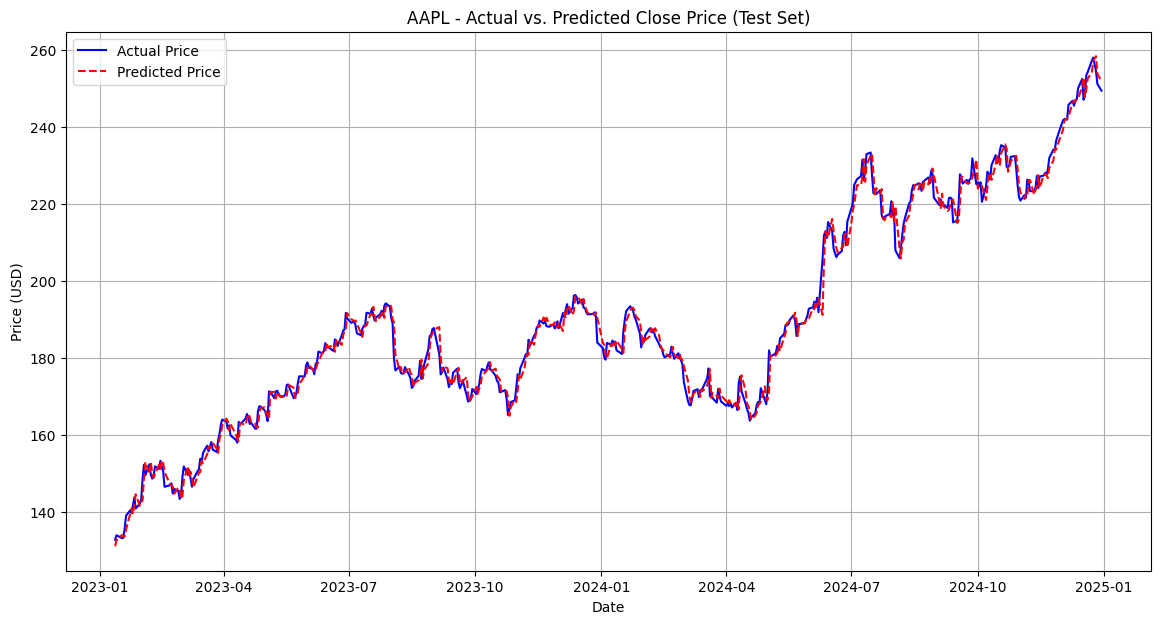

In [18]:
# Actual vs Predicted
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Price', color='red', linestyle='--')
plt.title(f'{TICKER} - Actual vs. Predicted Close Price (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# ✅ Project Complete
We successfully:
- Collected & cleaned Apple stock data  
- Engineered financial features  
- Built a Linear Regression model  
- Compared against a baseline  
- Visualized results & errors  